In [1]:
import numpy
import AGG

In [2]:
filename = "mt_test.annotated.gfa"
filename = "./HPRC/HG002.ccs.annotated.gfa"
graph = AGG.GraphicalGenome(filename=filename)

In [3]:
sanchor = "A000022"
for edge in graph.outgoing[sanchor]:
    var = graph.edges[edge].get("variants", "")
    if len(var) > 0:
        print(var)

22=


In [4]:

anchorlist = sorted(graph.anchor.keys())
anchorlist

['A000022',
 'A000044',
 'A000066',
 'A000088',
 'A000110',
 'A000132',
 'A000154',
 'A000176',
 'A000198',
 'A000220',
 'A000242',
 'A000264',
 'A000286',
 'A000308',
 'A000330',
 'A000352',
 'A000374',
 'A000396',
 'A000418',
 'A000440',
 'A000462',
 'A000484',
 'A000506',
 'A000528',
 'A000550',
 'A000572',
 'A000594',
 'A000616',
 'A000638',
 'A000660',
 'A000682',
 'A000704',
 'A000726',
 'A000748',
 'A000770',
 'A000792',
 'A000814',
 'A000836',
 'A000858',
 'A000880',
 'A000902',
 'A000924',
 'A000946',
 'A000968',
 'A000990',
 'A001012',
 'A001034',
 'A001056',
 'A001078',
 'A001100',
 'A001122',
 'A001144',
 'A001166',
 'A001188',
 'A001210',
 'A001232',
 'A001254',
 'A001276',
 'A001298',
 'A001320',
 'A001342',
 'A001364',
 'A001386',
 'A001408',
 'A001430',
 'A001452',
 'A001474',
 'A001496',
 'A001518',
 'A001540',
 'A001562',
 'A001584',
 'A001606',
 'A001628',
 'A001650',
 'A001672',
 'A001694',
 'A001716',
 'A001738',
 'A001760',
 'A001782',
 'A001804',
 'A001826',
 'A0

In [5]:
def get_position_count_from_cigar(cigar: str, ref_seq: str, alt_seq: str, ref_start: int, allelecount: int):

    poscount = {}
    ref_pos = 0
    alt_pos = 0
    
    # Parse CIGAR string into operations
    operations = []
    num = ""
    for c in cigar:
        if c.isdigit():
            num += c
        else:
            operations.append((int(num), c))
            num = ""
    
    # Process each operation
    for length, op in operations:
        if op == '=':  # Match
            for i in range(length):
                pos = ref_start + ref_pos + i
                poscount[pos] = poscount.get(pos, 0) + allelecount
            ref_pos += length

        elif op == 'X':  # Mismatch
            for i in range(length):
                pos=ref_start + ref_pos + i
                poscount[pos] = poscount.get(pos, 0) + allelecount
            ref_pos += length
            alt_pos += length

        elif op == 'I':  # Insertion
            pos=ref_start + ref_pos
            # poscount[pos] = poscount.get(pos, 0) + allelecount
            alt_pos += length
            
        elif op == 'D':  # Deletion
            pos=ref_start + ref_pos
            for i in range(length):
                pos=ref_start + ref_pos + i
                poscount[pos] = poscount.get(pos, 0) + allelecount
            ref_pos += length
            
    return poscount

def findBedge(Graph, src, dst, refstrain, k):
    # revision add first anchor
    paths = AGG.Find_all_Path_between_anchors(Graph, src, dst, {refstrain})
    subpaths = paths.subpath
    
    if len(subpaths) < 1:
        return ""
    for p, strain in subpaths:
        seq = AGG.reconstruct_path_seq(Graph, path = p)
    return seq[:-k] 

In [6]:
ref_name = "NC_012920.1"
k = 21
# count coverage for each base position on chrM
mtlength = 16569
coverage = numpy.zeros(16569)

edgelist = sorted(graph.edges.keys())
for edge in edgelist:
    cigar = graph.edges[edge].get("variants", "")
    allele_count = len(graph.edges[edge].get('reads', []))
    if len(cigar) == 0:
        continue
    src = graph.edges[edge]['src'][0]
    dst = graph.edges[edge]['dst'][0]
    ref_start = int(graph.anchor.get(src, {}).get("pos", 0))
    ref_seq = findBedge(graph, src, dst, ref_name, k)
    alt_seq = graph.anchor.get(src, {}).get('seq', "") + graph.edges[edge]['seq']

    poscount = get_position_count_from_cigar(cigar, ref_seq, alt_seq, ref_start, allele_count)
    for pos, count in poscount.items():
        coverage[pos-1] += count

In [7]:
from matplotlib import pyplot as plt

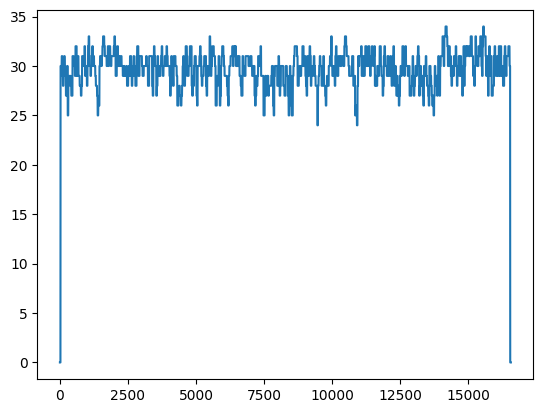

In [8]:
plt.plot(coverage)

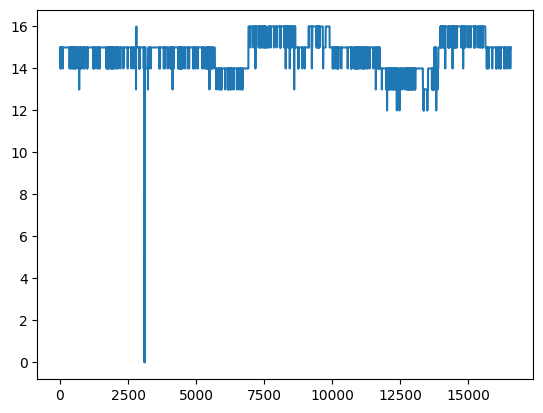

In [9]:
filename = "./HPRC/HG002_mt.bam.depth"
with open(filename, 'r') as fp:
    data = fp.readlines()
poslist = []
countlist = []
for line in data:
    itemlist = line[:-1].split('\t')
    poslist.append(int(itemlist[1]))
    countlist.append(int(itemlist[2]))

plt.plot(poslist, countlist)

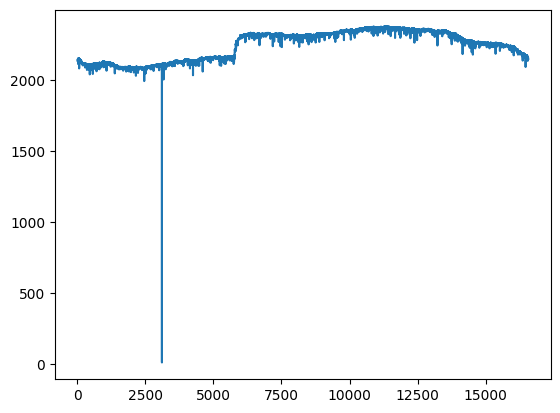

In [58]:
filename = "mt_test.bam.depth"
with open(filename, 'r') as fp:
    data = fp.readlines()
poslist = []
countlist = []
for line in data:
    itemlist = line[:-1].split('\t')
    poslist.append(int(itemlist[1]))
    countlist.append(int(itemlist[2]))

plt.plot(poslist, countlist)

In [35]:
# calculate AF in vcf file
with open("mt_filtered.reheadered.vcf", 'r') as fp:
    data = fp.readlines()

allele_frequency_list = []
for line in data:
    if line.startswith("#"):
        continue
    itemlist = line[:-1].split('\t')
    position = int(itemlist[1])
    readcount = itemlist[-1].split('=')[1]
    allele_frequency = float(readcount)/float(coverage[position-1])
    allele_frequency_list.append(allele_frequency)

In [45]:
allele_frequency_list = numpy.array(allele_frequency_list)
numpy.sum(allele_frequency_list>0.9), numpy.sum(allele_frequency_list<0.01),

(14, 3827)

In [57]:
AF_list = allele_frequency_list[numpy.where(allele_frequency_list > 0.01)[0]]
A = sorted(AF_list)


In [65]:
# AF distribution
# calculate AF in vcf file
with open("mt_filtered_45_withAF.vcf", 'r') as fp:
    data = fp.readlines()

allele_frequency_list = []
for line in data:
    if line.startswith("#"):
        continue
    itemlist = line[:-1].split('\t')
    AF_info = itemlist[-1].split(';')[2]
    allele_frequency = float(AF_info.split('=')[1])
    allele_frequency_list.append(allele_frequency)

<Axes: >

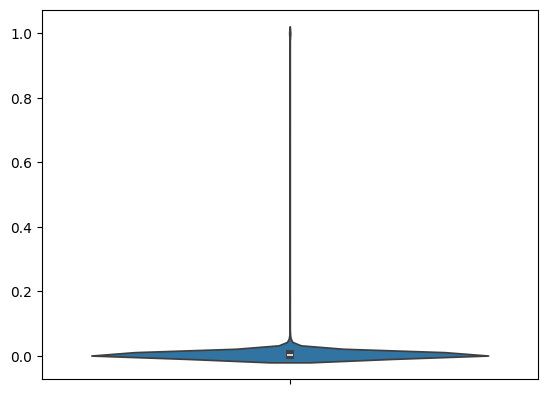

In [83]:
import seaborn as sns
sns.violinplot(allele_frequency_list)


Text(0, 0.5, 'log10 (Site number + 1)')

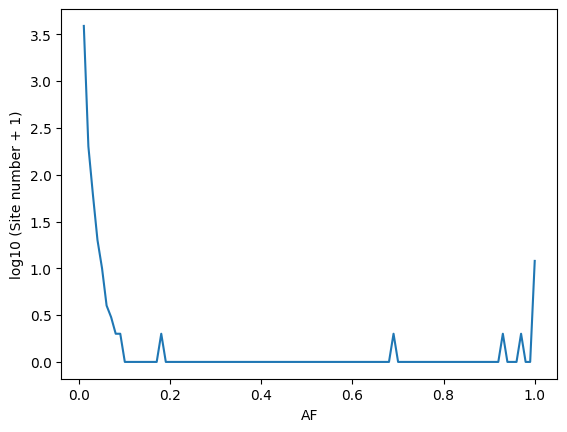

In [79]:
y, x= numpy.histogram(allele_frequency_list, bins = 100)
plt.plot(x[1:], numpy.log10(y+1))
plt.xlabel("AF")
plt.ylabel("log10 (Site number + 1)")